In [46]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

In [119]:
pppalette = ['#3b429f', '#82C7A5', '#6a8eae', '#AF3E4D', '#F15E22', '#1B212C']

C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\1711337404.py:3: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')


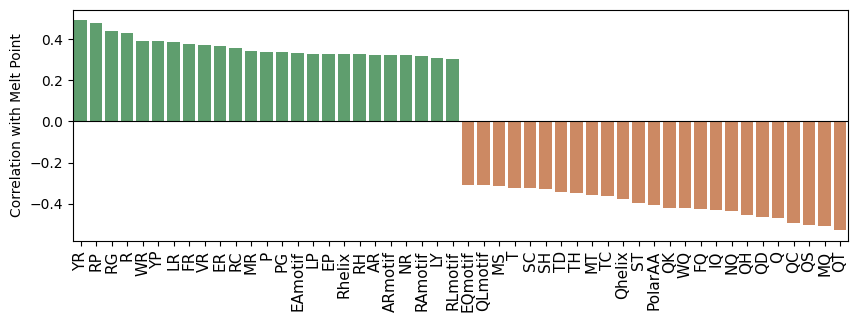

In [121]:
# Correlation analysis, 25 strongest positive and negative correlations with melt point are shown in plot
palette = sns.color_palette("deep")
prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')
droplist = [1,3,4,5,6,9,10,12,13,14,15,16,17,18]
prokaryotes = prokaryotes.drop(prokaryotes.columns[droplist], axis=1)
correlation = prokaryotes.corr(numeric_only=True)['meltPoint'].sort_values(ascending=False)
corrhighlow = pd.concat([correlation[1:30],correlation[-30:]])
plt.figure(figsize=(10, 3))
sns.barplot(data=correlation[1:26], color=palette[2])
sns.barplot(data = correlation[-25:], color = palette[1])
plt.xticks(rotation=90, fontsize = 11)
plt.ylabel('Correlation with Melt Point')
plt.axhline(0, color='black', linewidth=0.8, linestyle='-')
plt.savefig('./data/figs/Correlationplot.svg', format='svg', dpi=1000)
plt.show()

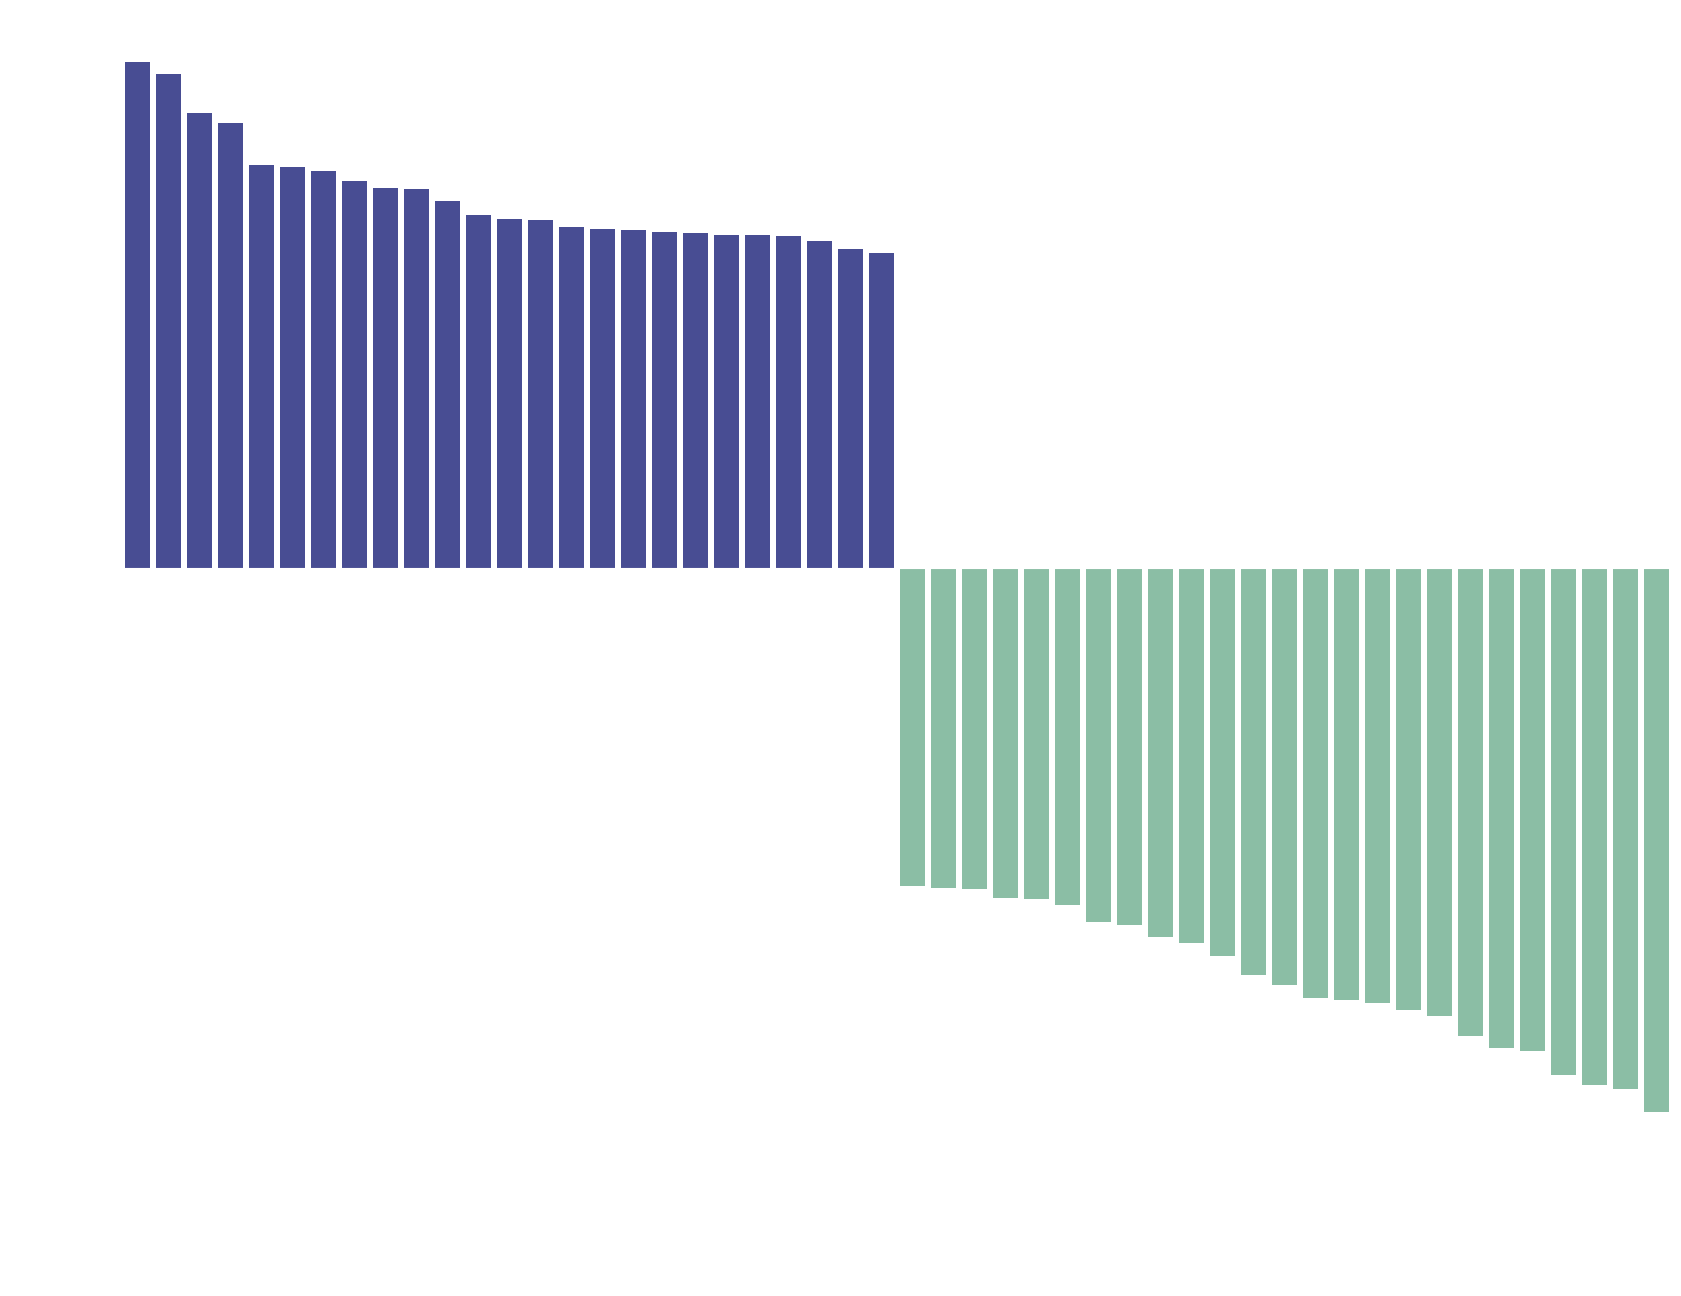

In [135]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(data=correlation[1:26], color=pppalette[0])
sns.barplot(data = correlation[-25:], color = pppalette[1])
plt.xticks(rotation=90, fontsize = 20, color = 'white')
plt.ylabel('Correlation with Melt Point', color = 'white', fontsize = 22)
plt.axhline(0, color='white', linewidth=0.8, linestyle='-')
plt.yticks(color = 'white', fontsize = 20)
ax.spines['top'].set_color('white')  
ax.spines['right'].set_color('white') 
ax.spines['left'].set_color('white')  
ax.spines['bottom'].set_color('white')
ax.tick_params(axis='x', colors='white') 
ax.tick_params(axis='y', colors='white')  
plt.savefig('./data/figs/Correlationplotppt.svg', format='svg', dpi=1000, transparent=True)
plt.show()

In [47]:
# Data Preprocessing and PCA + Loadings
prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')
droplist = [0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,37,40,41,42,45,306,327]
droplist2 = [0,1,2,3,4,5,6,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,37,40,41,42,45,306,327]
prokaryotesmp = pd.read_csv('./data/prokaryotes_348columns.csv').drop(prokaryotes.columns[droplist2], axis=1)
prokaryotespca = prokaryotes.drop(prokaryotes.columns[droplist], axis=1)
prokaryotespca.replace([np.inf, -np.inf], np.nan, inplace=True)
prokaryotespca = prokaryotespca.fillna(0)
prokaryotespca = prokaryotespca.reset_index(drop=True)
scaler = StandardScaler()
pca = PCA(n_components=25)
prokaryotesscaled = scaler.fit_transform(prokaryotespca)
PCA_prokaryotes = PCA().fit(prokaryotesscaled)
eigenvalues = PCA_prokaryotes.explained_variance_
variance = PCA_prokaryotes.explained_variance_ratio_
prokaryotes_PCA = pca.fit_transform(prokaryotesscaled)
prokaryotes_PCA_df = pd.DataFrame(data = prokaryotes_PCA, columns = [f'PC{i+1}' for i in range(25)])
loadings = PCA(n_components=25).fit(prokaryotesscaled).components_.T
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=prokaryotespca.columns)

C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\769840671.py:2: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')
C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\769840671.py:5: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotesmp = pd.read_csv('./data/prokaryotes_348columns.csv').drop(prokaryotes.columns[droplist2], axis=1)


In [48]:
variance2 = PCA(n_components=2).fit(prokaryotesscaled).explained_variance_ratio_

In [49]:
# Dividing proteins into low melting point, mid melting point, and high melting point
q1 = prokaryotes['meltPoint'].quantile(0.20)
q2_low = prokaryotes['meltPoint'].quantile(0.4)
q2_high = prokaryotes['meltPoint'].quantile(0.6)
q3 = prokaryotes['meltPoint'].quantile(0.8)
def categorize_meltpoint(meltpoint):
    if meltpoint <= q1:
        return 'low_Tm'
    elif q2_low <= meltpoint <= q2_high:
        return 'mid_Tm'
    elif meltpoint >= q3:
        return 'high_Tm'
    else:
        return 'other'
prokaryotes_PCA_df['meltPointGroup'] = prokaryotes['meltPoint'].apply(categorize_meltpoint)

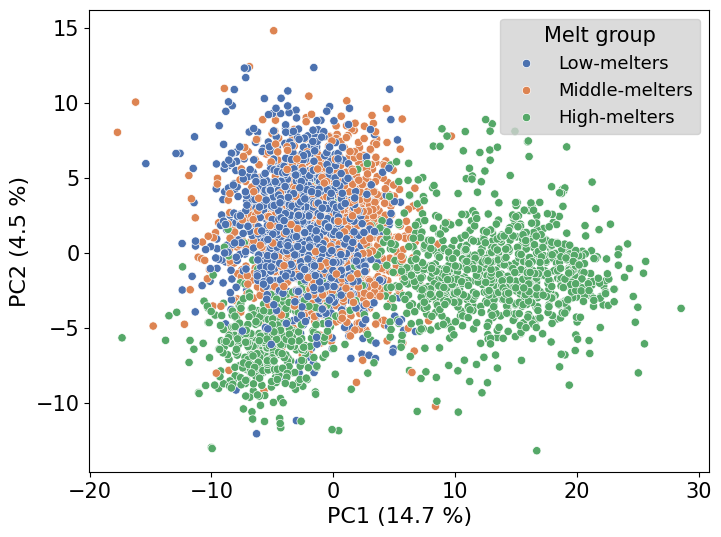

In [149]:
# PC1 vs PC2 plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data = prokaryotes_PCA_df[prokaryotes_PCA_df['meltPointGroup'].isin(['high_Tm','mid_Tm','low_Tm'])], x = 'PC1', y = 'PC2', hue = 'meltPointGroup',palette = 'deep')
plt.xlabel('PC1 (14.7 %)',fontsize = 16)
plt.ylabel('PC2 (4.5 %)',fontsize = 16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
legend = plt.legend(title='Melt group', fontsize=13, title_fontsize=15, facecolor='lightgrey')
legend.get_texts()[0].set_text('Low-melters')
legend.get_texts()[1].set_text('Middle-melters')
legend.get_texts()[2].set_text('High-melters')
plt.savefig('./data/figs/PCAplot.svg', format='svg', dpi=1000)
plt.show()

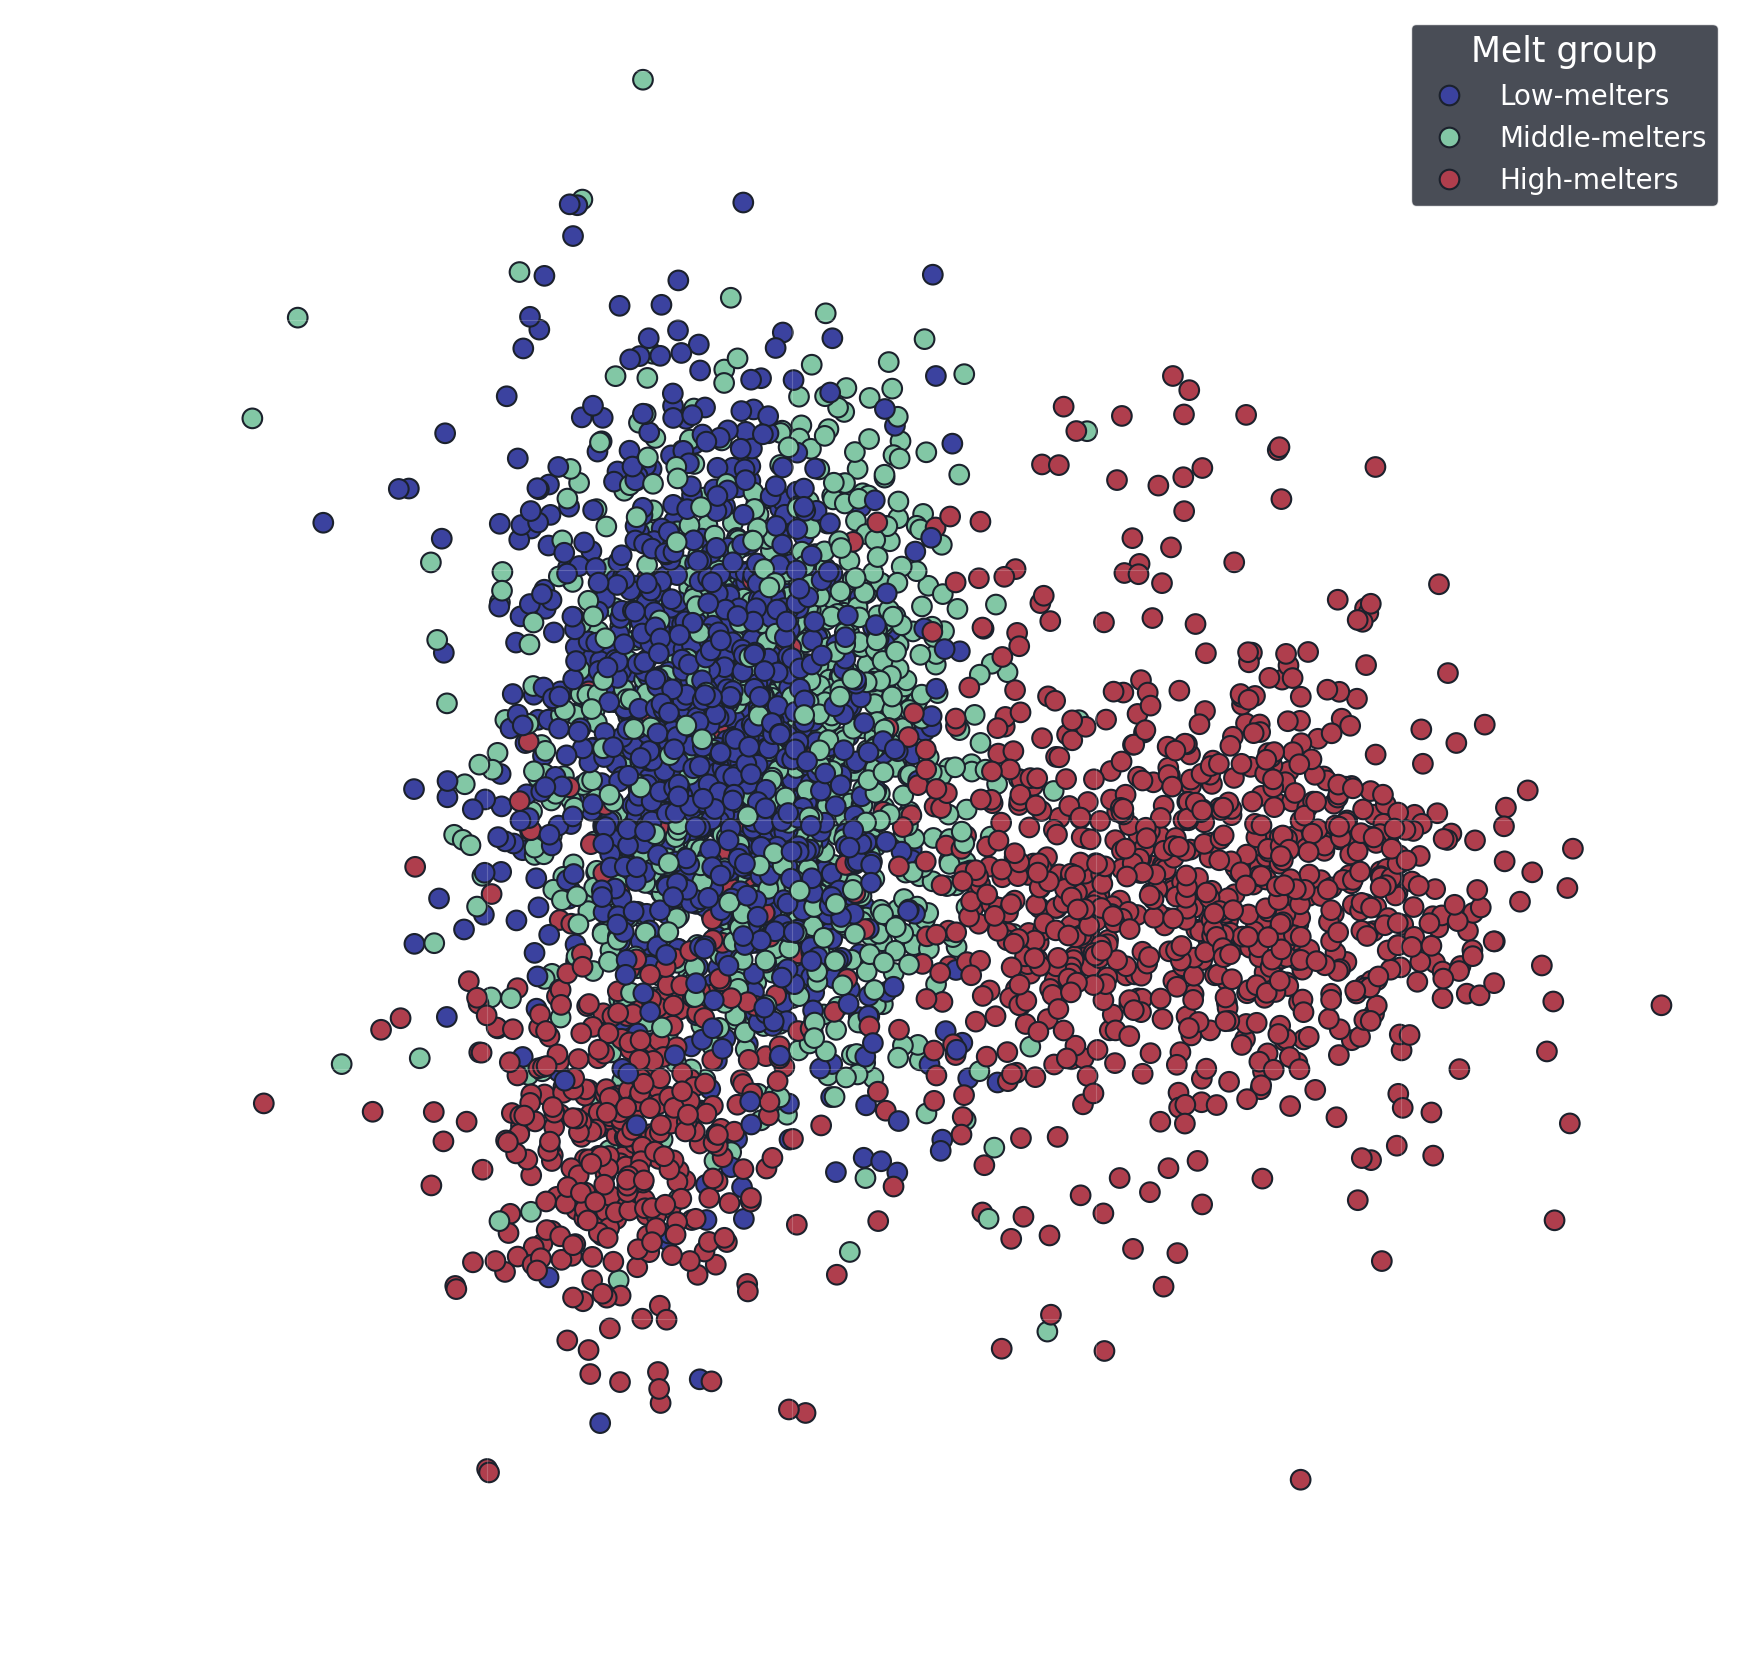

In [167]:
# PC1 vs PC2 plot powerpoint version
fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(data = prokaryotes_PCA_df[prokaryotes_PCA_df['meltPointGroup'].isin(['high_Tm','mid_Tm','low_Tm'])], x = 'PC1', y = 'PC2', hue = 'meltPointGroup',palette = [pppalette[0], pppalette[1], pppalette[3]], s = 200, edgecolor = pppalette[5], linewidth = 1.5)
plt.xlabel('PC1 (14.7 %)',fontsize = 40, color = 'white')
plt.ylabel('PC2 (4.5 %)',fontsize = 40, color = 'white')
plt.xticks(fontsize = 35, color = 'white')
plt.yticks(fontsize = 35, color = 'white')
legend = plt.legend(title='Melt group', fontsize=20, title_fontsize=25, facecolor=pppalette[5], edgecolor = 'white')
legend.get_texts()[0].set_text('Low-melters')
legend.get_texts()[1].set_text('Middle-melters')
legend.get_texts()[2].set_text('High-melters')
for text in legend.get_texts():
    text.set_color('white')
legend.get_title().set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.grid(color = 'white', alpha = 0.2, zorder = 0)
plt.savefig('./data/figs/PCAplotppt.svg', format='svg', dpi=1000, transparent = True)
plt.show()

In [51]:
# features with high positive or high negative impact on PC1 OR PC2
subsetpc = loadings_df[(loadings_df['PC1'] >= loadings_df['PC1'].quantile(0.9)) | (loadings_df['PC2'] <= loadings_df['PC2'].quantile(0.1))][['PC1','PC2']]
# features with high positive and high negative impact on PC1 AND PC2
subsetpc2 = loadings_df[(loadings_df['PC1'] >= loadings_df['PC1'].quantile(0.8)) & (loadings_df['PC2'] <= loadings_df['PC2'].quantile(0.2))][['PC1','PC2']]
print(f'High positive impact on PC1 and high negative impact on PC2:\n{subsetpc2}')

High positive impact on PC1 and high negative impact on PC2:
              PC1       PC2
VR       0.110776 -0.040403
MR       0.085942 -0.064819
FR       0.093844 -0.047732
YR       0.078228 -0.116083
ER       0.098780 -0.086540
EP       0.095171 -0.048901
EG       0.084965 -0.063828
RH       0.102224 -0.040357
RC       0.100975 -0.053209
RG       0.120245 -0.043425
R        0.112172 -0.060523
ERmotif  0.062220 -0.045735
REmotif  0.066659 -0.041075
RRmotif  0.073626 -0.033892
GRmotif  0.062840 -0.037226
Rhelix   0.082317 -0.049330


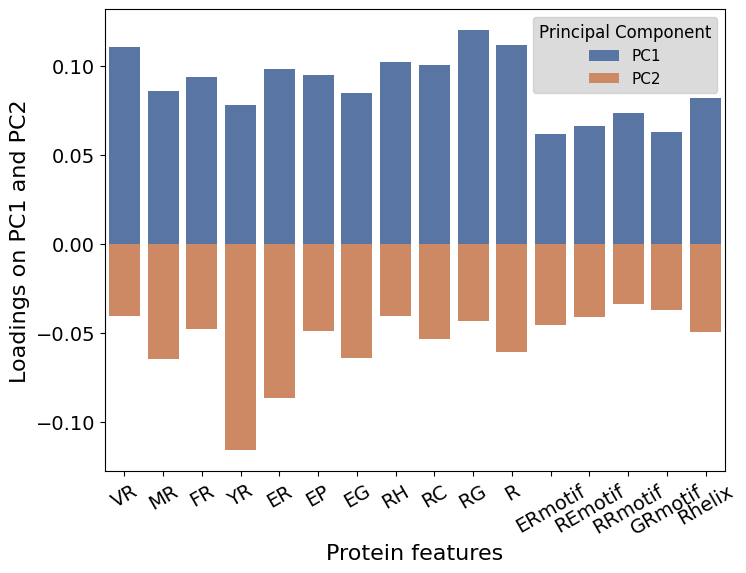

In [171]:
# loadings plot for PC1 and PC2
subsetpc2['variables'] = subsetpc2.index
subsetpc_long = subsetpc2.reset_index().melt(id_vars='variables', value_vars=['PC1', 'PC2'], var_name='PrincipalComponent', value_name='Loadings')
plt.figure(figsize=(8, 6))
sns.barplot(data=subsetpc_long, x='variables', y='Loadings', hue='PrincipalComponent',dodge = False, palette='deep')
plt.xticks(rotation=30, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Protein features',fontsize = 16)
plt.ylabel('Loadings on PC1 and PC2', fontsize = 16)
ax = plt.gca()  # Get the current axes
legend = plt.legend(title='Principal Component', fontsize=11, title_fontsize=12, facecolor='lightgrey',loc = 'upper right')
legend.get_texts()[0].set_text('PC1')
legend.get_texts()[1].set_text('PC2')
plt.savefig('./data/figs/loadingsplot.svg', format='svg', dpi=1000)
plt.show()


C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\752289178.py:6: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(data=subsetpc_long, x='variables', y='Loadings', hue='PrincipalComponent',dodge = False, palette=pppalette)


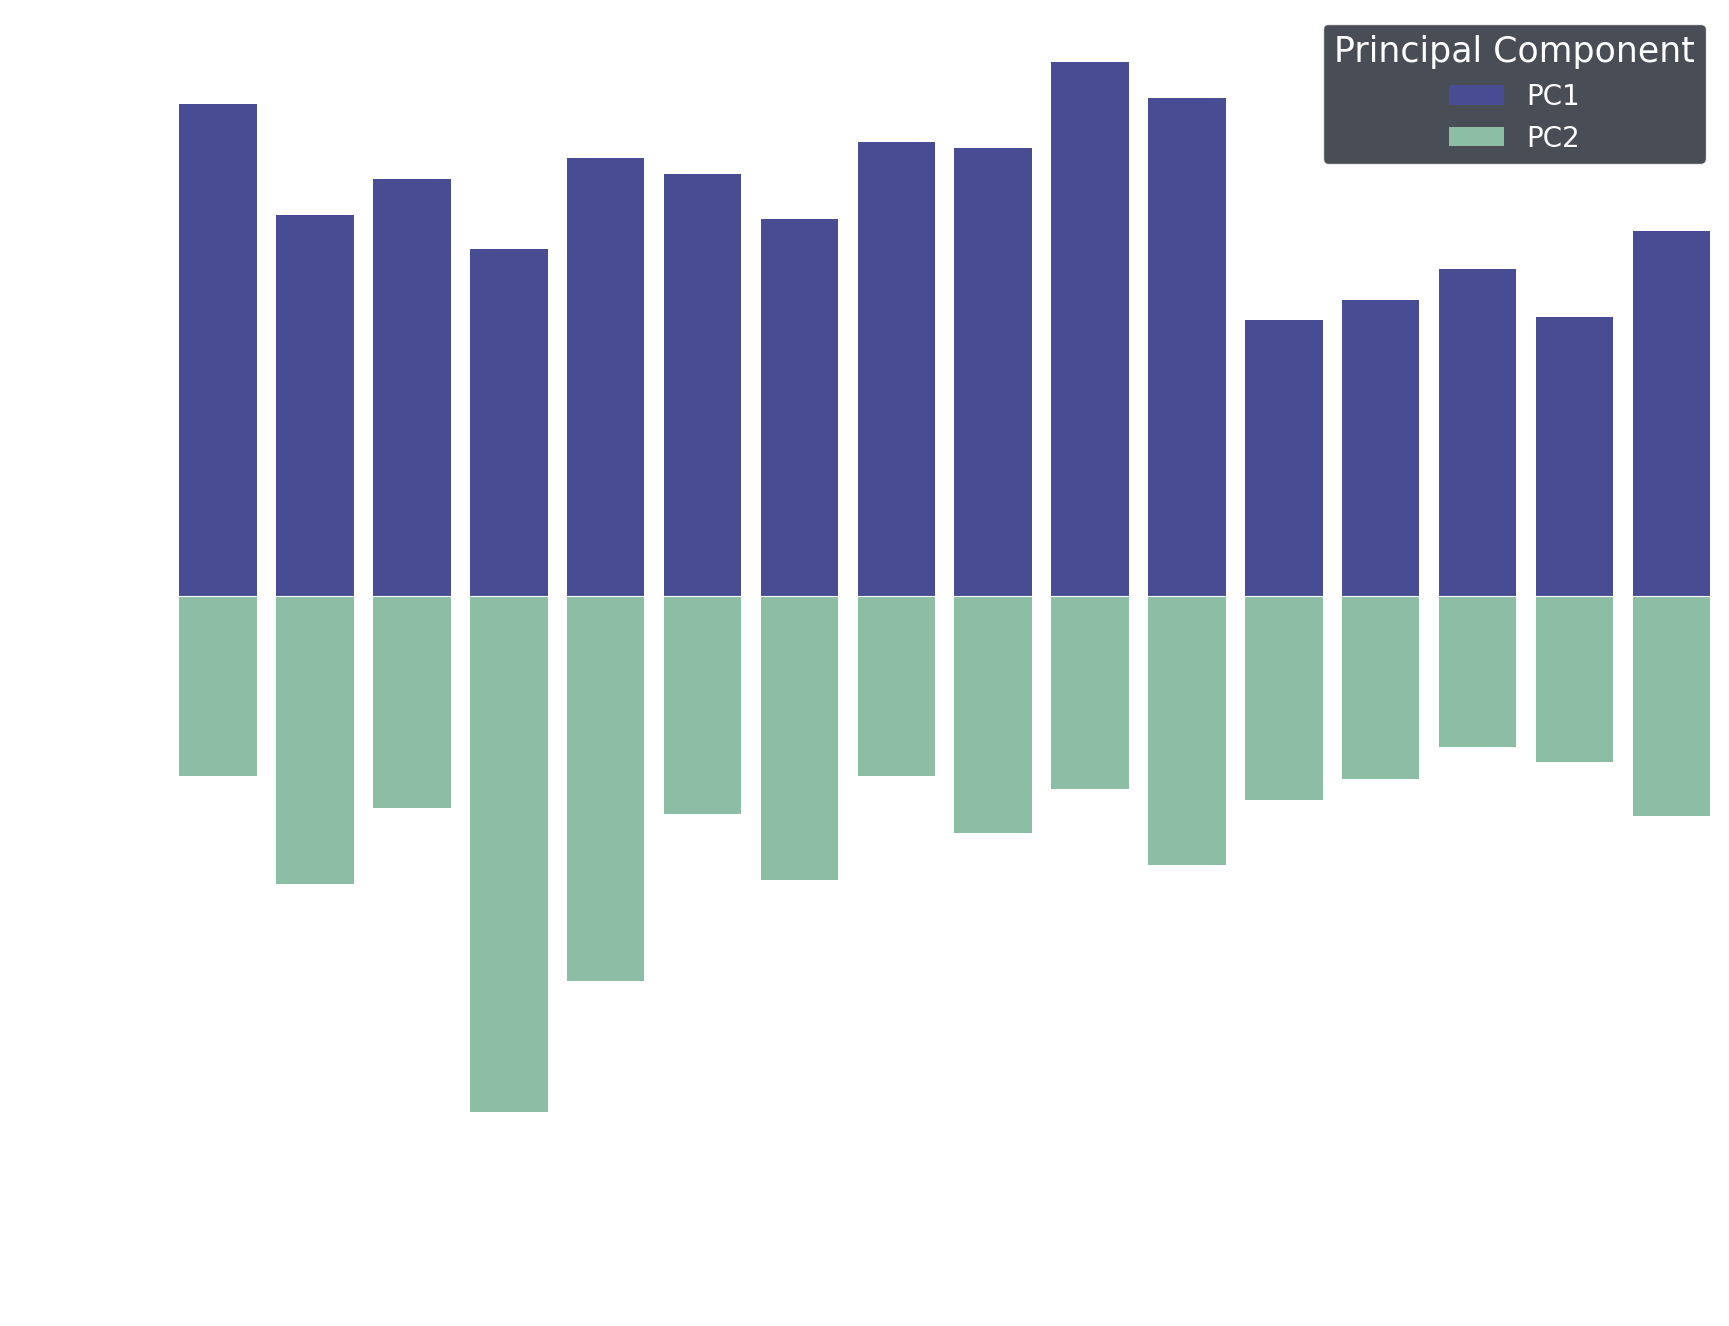

In [174]:
# loadings plot for PC1 and PC2, powerpoint version
subsetpc2['variables'] = subsetpc2.index
subsetpc_long = subsetpc2.reset_index().melt(id_vars='variables', value_vars=['PC1', 'PC2'], var_name='PrincipalComponent', value_name='Loadings')
plt.show()
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(data=subsetpc_long, x='variables', y='Loadings', hue='PrincipalComponent',dodge = False, palette=pppalette)
plt.xticks(rotation=90, fontsize = 25, color = 'white')
plt.ylabel('Loadings on PC1 and PC2', color = 'white', fontsize = 28)
plt.axhline(0, color='white', linewidth=0.8, linestyle='-')
plt.yticks(color = 'white', fontsize = 25)
ax.spines['top'].set_color('white')  
ax.spines['right'].set_color('white') 
ax.spines['left'].set_color('white')  
ax.spines['bottom'].set_color('white')
legend = plt.legend(title='Principal Component', fontsize=20, title_fontsize=25, facecolor=pppalette[5], edgecolor = 'white')
legend.get_texts()[0].set_text('PC1')
legend.get_texts()[1].set_text('PC2')
for text in legend.get_texts():
    text.set_color('white')
legend.get_title().set_color('white')
ax.tick_params(axis='x', colors='white') 
ax.tick_params(axis='y', colors='white')
plt.xlabel('')
plt.savefig('./data/figs/loadingsplotppt.svg', format='svg', dpi=1000, transparent=True)
plt.show()

In [34]:
# comparing the performance of different regression models after PCA
prokaryotes_regression = pd.read_csv('./data/prokaryotes_348columns.csv')
droplist = [0,1,2,3,4,5,6,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,37,40,41,42,45,282,283,284,285,286,287,288,289,290,291,292,293,294,300,301,302,303,304,305,306,327]
prokaryotes_regression = prokaryotes_regression.drop(prokaryotes_regression.columns[droplist], axis=1)
prokaryotes_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
prokaryotes_regression = prokaryotes_regression.fillna(0)
prokaryotes_regression = prokaryotes_regression.reset_index(drop=True)
X = prokaryotes_regression.drop('meltPoint', axis=1)
y = prokaryotes_regression['meltPoint']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=1)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)                 # Train each model
    y_pred = model.predict(X_test)              # Predict on test data
    mse = mean_squared_error(y_test, y_pred)    # Calculate the MSE and r2 for each model to compare performance
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'R²': r2}

# Print the results
for name, metrics in results.items():
    print(f"{name} - MSE: {metrics['MSE']:.2f}, R²: {metrics['R²']:.2f}")

C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\3326076931.py:2: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes_regression = pd.read_csv('./data/prokaryotes_348columns.csv')


Linear Regression - MSE: 117.14, R²: 0.52
Ridge Regression - MSE: 117.14, R²: 0.52
Lasso Regression - MSE: 122.48, R²: 0.50
Random Forest - MSE: 59.37, R²: 0.76
Gradient Boosting - MSE: 63.67, R²: 0.74


In [35]:
Forest = RandomForestRegressor(max_depth = 20,max_features = 'sqrt',n_estimators = 300,random_state = 1).fit(X_train, y_train)
gbr = GradientBoostingRegressor().fit(X_train, y_train)

In [36]:
#compare for high mp, Gradient Boosting outperforms Random Forest for high melting point proteins, therefore GBR is used for further application
highmpx = X_test[np.where(y_test.astype(float)>61)]
highmpy = y_test[y_test.astype(float)>61].astype(float)
yforest = Forest.predict(highmpx)
ygradient = gbr.predict(highmpx)
print(mean_squared_error(highmpy, yforest))
print(mean_squared_error(highmpy, ygradient))

97.58033435225948
98.1690621092089


In [37]:
#Performing an f-test (first on a linear regression model) to test the significance of the model
from sklearn.linear_model import LinearRegression
from scipy.stats import f
linear = LinearRegression().fit(X_train, y_train)
y_pred_linear = linear.predict(X_test)
residuals_linear = y_test - y_pred_linear
RSS = np.sum(residuals_linear**2)  # Residual Sum of Squares
TSS = np.sum((y_train - np.mean(y_train))**2)  # Total Sum of Squares
n = len(y_test)
p = X_train.shape[1]
f_statistic = ((TSS - RSS) / p) / (RSS / (n - p - 1))   # F-statistic of 382.66
p_value = 1 - f.cdf(f_statistic, p, n - p - 1)          # p-value of 1.11e-16, linear regression model is significant
print(f'f-statistic: {f_statistic}, p-value: {p_value}')
# next step is to test whether the gradient boosting regressor model is significantly better than the linear model
y_pred_gbr = gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mse_lr = mean_squared_error(y_test, y_pred_linear)
n = len(y_test)
p1 = X_train.shape[1]  # Number of predictors in the linear model
p2 = 1  # Number of predictors in the gradient boosting model (for F-test, we use it as one overall)
f_statistic2 = ((mse_lr - mse_gbr) / (p1 - p2)) / (mse_gbr / (n - p2)) # calculate F-statistic of 45.8
p_value2 = 1 - f.cdf(f_statistic2, p1 - p2, n - p2)  # calculate p-value of 1.11e-16, gradient boosting model is significantly better than linear model, which is significant therefore our model is significant
print(f"F-statistic: {f_statistic2}")
print(f"P-value: {p_value2}")

f-statistic: 382.6556637057478, p-value: 1.1102230246251565e-16
F-statistic: 46.053290826722005
P-value: 1.1102230246251565e-16


In [38]:
palette = sns.color_palette('deep')
prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')
proteinnames = prokaryotes.copy()['Protein_ID']
droplist = [0,1,2,3,4,5,6,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,37,40,41,42,45,282,283,284,285,286,287,288,289,290,291,292,293,294,300,301,302,303,304,305,306,327]
prokaryotes = prokaryotes.drop(prokaryotes.columns[droplist], axis=1)
prokaryotes.replace([np.inf, -np.inf], np.nan, inplace=True)
prokaryotes = prokaryotes.fillna(0)
prokaryotes = prokaryotes.reset_index(drop=True)
meltPoints = prokaryotes['meltPoint']
prokaryotes = prokaryotes.drop('meltPoint', axis=1)
prokaryotesscaled = scaler.transform(prokaryotes)
prokaryotespca = pca.transform(prokaryotesscaled)
meltdf = pd.DataFrame({'meltPointpred': model.predict(prokaryotespca), 'meltPoint' : meltPoints})
meltdf['predround'] = meltdf['meltPointpred'].round()
def calculate_rmse(group):
    rmse = np.sqrt(mean_squared_error(group['meltPoint'], group['meltPointpred']))
    count = len(group)  
    return pd.Series({'RMSE': rmse, 'Count': count})
grouped_rmse = meltdf.groupby('predround').apply(lambda x: calculate_rmse(x))
binsize = 3
bins = list(range(38, 93,binsize))
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
meltdf['rounded2'] = pd.cut(meltdf['meltPointpred'], bins, labels=labels)
grouped_rmse2 = meltdf.groupby('rounded2').apply(lambda x: calculate_rmse(x))
print(grouped_rmse2)

               RMSE   Count
rounded2                   
38-41      9.004864     5.0
41-44      4.274303   326.0
44-47      5.378486  1953.0
47-50      6.929736  1618.0
50-53      8.920756   515.0
53-56     11.560731   207.0
56-59     14.003502   139.0
59-62     14.773119   129.0
62-65     13.998888   131.0
65-68      9.551097   156.0
68-71      6.843724   272.0
71-74      7.081214   232.0
74-77      8.688735    72.0
77-80      8.597306    48.0
80-83      5.595393   251.0
83-86      5.136974   443.0
86-89      5.074434    56.0
89-92      4.548742     3.0


C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\836978543.py:2: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes = pd.read_csv('./data/prokaryotes_348columns.csv')
C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\836978543.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = meltdf.groupby('predround').apply(lambda x: calculate_rmse(x))
C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\836978543.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

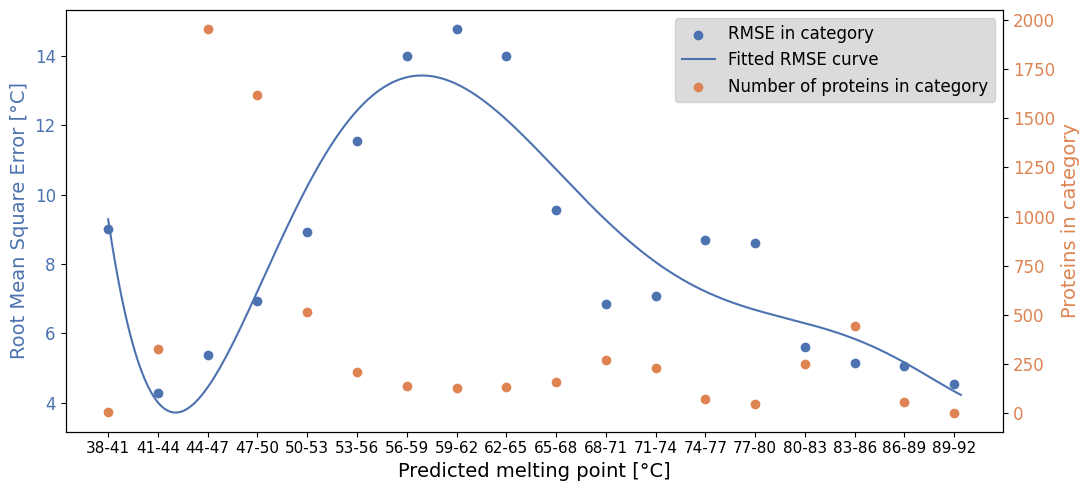

In [117]:
# Determining a function for the temperature dependent RMSE of the model
from scipy.optimize import curve_fit
def model_func(x, a,b,c,d,e,f,g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g
x_values = np.array([39.5,42.5,45.5,48.5,51.5,54.5,57.5,60.5,63.5,66.5,69.5,72.5,75.5,78.5,81.5,84.5,87.5,90.5])
x_values2 = np.arange(39.5,91,0.1)
popt, pcov = curve_fit(model_func, x_values, grouped_rmse2['RMSE'])
#print(f"Optimal parameters: {popt}")
fig, ax1 = plt.subplots(figsize=(11, 5))
x = np.linspace(39, 93, 1)
# Scatter plot for y1
ax1.scatter(data =grouped_rmse2, x = x_values, y = 'RMSE', color=palette[0], label='RMSE in category')
ax1.set_xlabel('Predicted melting point [°C]', fontsize = 14)
ax1.set_ylabel('Root Mean Square Error [°C]', color=palette[0], fontsize = 14)
ax1.tick_params(axis='y', labelcolor=palette[0], labelsize = 12)
# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.scatter(data =grouped_rmse2, x = x_values, y = 'Count', color=palette[1], label='Number of proteins in category')
ax2.set_ylabel('Proteins in category', color=palette[1], fontsize = 14)
ax2.tick_params(axis='y', labelcolor=palette[1], labelsize = 12)
x_fit = x_values2
y_fit = model_func(x_fit, *popt)
ax1.plot(x_fit, y_fit, color=palette[0], label='Fitted RMSE curve')
# Add titles and legends
fig.tight_layout()
fig.legend(loc="upper right",bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes,facecolor = 'lightgrey', fontsize = 12)
ax1.set_xticks(x_values)
ax1.set_xticklabels(grouped_rmse2.index, fontsize=11)
plt.savefig('./data/figs/regressionerror.svg', format='svg', dpi=1000)
plt.show()

In [40]:
# testing regression with only proteins with crystal structure, shows no significant improvement from regression using s4pred
prokaryotes348 = pd.read_csv('./data/prokaryotes_348columns.csv')
prokaryotescrystal = prokaryotes348.dropna(subset=['Helix','Beta strand'],thresh = 1)
prokaryotescrystalcopy = prokaryotescrystal.copy()
prokaryotescrystal = prokaryotescrystal.drop(prokaryotescrystal.columns[droplist2], axis=1)
prokaryotescrystal.replace([np.inf, -np.inf], np.nan, inplace=True)
prokaryotescrystal = prokaryotescrystal.fillna(0)
prokaryotescrystal = prokaryotescrystal.reset_index(drop=True)
X_crys = prokaryotescrystal.drop('meltPoint', axis=1)
y_crys = prokaryotescrystal['meltPoint']
scaler_crys = StandardScaler()
X_scaled_crys = scaler.fit_transform(X_crys)
pca_crys = PCA(n_components=25)
X_pca_crys = pca_crys.fit_transform(X_scaled)
X_train_crys, X_test_crys, y_train_crys, y_test_crys = train_test_split(X_pca, y, test_size=0.2, random_state=1)
gbr_crys = GradientBoostingRegressor(random_state=1).fit(X_train_crys, y_train_crys)
y_pred_crys = gbr_crys.predict(X_test_crys)
print(r2_score(y_test_crys, y_pred_crys)) 
print(mean_squared_error(y_test_crys, y_pred_crys))

C:\Users\tobia\AppData\Local\Temp\ipykernel_23128\1476180641.py:2: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes348 = pd.read_csv('./data/prokaryotes_348columns.csv')


0.741593568873295
63.654350978229445


In [41]:
# Computing R2, PCC and RMSE of model as mean of 10 seeds
from scipy.stats import pearsonr
r2s = []
rmses = []
pccs = []
for n in [1,2,3,4,5,6,7,8,9,10]:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=n)
    modeln = GradientBoostingRegressor(random_state=1).fit(X_train, y_train)
    y_pred = modeln.predict(X_test)
    r2s.append(r2_score(y_test, y_pred))
    rmses.append(mean_squared_error(y_test, y_pred))
    pccs.append(pearsonr(y_test, y_pred))
print(f"Mean of R2: {np.mean(r2s)}")
print(f"Mean of RMSE: {np.mean(rmses)}")
print(f"Mean of PCC: {np.mean([pcc[0] for pcc in pccs])}")
print(f'Max r2 for n = {np.argmax(r2s)+1} is {np.max(r2s)}')
print(f'Min RMSE for n = {np.argmin(rmses)+1} is {np.min(rmses)}')
print(f'Max PCC for n = {np.argmax([pcc[0] for pcc in pccs])+1} is {np.max([pcc[0] for pcc in pccs])}')

Mean of R2: 0.7189817011189098
Mean of RMSE: 69.15127894348858
Mean of PCC: 0.8480052180772086
Max r2 for n = 1 is 0.741593568873295
Min RMSE for n = 1 is 63.654350978229445
Max PCC for n = 1 is 0.8612840655179471


In [45]:
compare = pd.DataFrame()
compare['Crystalhelixcount'] = prokaryotescrystalcopy['Helix1count'].astype(float)
compare['S4predhelixcount'] = prokaryotescrystalcopy['Helix2count'].astype(float)
compare['Crystalsheetcount'] = prokaryotescrystalcopy['Sheet1count'].astype(float)
compare['S4predsheetcount'] = prokaryotescrystalcopy['Sheet2count'].astype(float)
compare['diffS4helixcount'] = compare.apply(lambda x: abs((x['S4predhelixcount']-x['Crystalhelixcount'])/x['Crystalhelixcount']) if x['Crystalhelixcount'] != 0 and x['S4predhelixcount'] else np.nan, axis=1)
S4errorhelix = np.nanmean(np.array(compare['diffS4helixcount']))
print(f'Error for predicted number of helices: {S4errorhelix}')
compare['diffS4sheetcount'] = compare.apply(lambda x: abs((x['S4predsheetcount']-x['Crystalsheetcount'])/x['Crystalsheetcount']) if x['Crystalsheetcount'] != 0 and x['S4predsheetcount'] else np.nan, axis=1)
S4errorsheet = np.nanmean(np.array(compare['diffS4sheetcount']))
print(f'Error for predicted number of beta sheets: {S4errorsheet}')
print(f'Mean of helix count and sheet count error:{np.mean([S4errorhelix,S4errorsheet])}')

Error for predicted number of helices: 0.43304591024459743
Error for predicted number of beta sheets: 0.3905699431608697
Mean of helix count and sheet count error:0.4118079267027336
Error for predicted perc of helices: 0.49356535623993175
Error for predicted perc of beta sheets: 0.4541597304902757
Mean of helix perc and sheet perc error:0.4738625433651037
